#Stephen Lanna
#Lab 7
#04/01/2023

Libraries needed

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import re
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


device(type='cpu')

Preprocessing the tweets

In [2]:
def remove_links_mentions(tweet):
  # Preprocessing the tweets by removing links and mentions
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

Getting train, validation, and test sets

In [3]:
def read_tweets_get_vectors(tweet_file):
    df = pd.read_csv(tweet_file, sep=',', header=0)
    dic_result = {}
    df1 = df[['tweet_id', 'text', 'airline_sentiment']]
    count = 0
    for index in range(len(df1)):
        try:
            label = df.loc[index, "airline_sentiment"]
            tweet_id = df.loc[index, "tweet_id"]
            if label in dic_result:
                dic_result[label][tweet_id] = remove_links_mentions(df.loc[index, "text"])
            else:
                dic_result[label] = {tweet_id: remove_links_mentions(df.loc[index, "text"])}
        except:
            count += 1
    return dic_result


def split_data(twitter_data):
    training = []
    validation = []
    test = []

    for label in twitter_data:
        temp_dic = twitter_data[label]
        lst_tweet_ids = list(temp_dic.keys())
        train_length = int(len(lst_tweet_ids) * 0.8)
        train_ids = lst_tweet_ids[:train_length]
        remaining = lst_tweet_ids[train_length:]
        test_lenght = int(len(remaining) * 0.5)
        test_ids = remaining[:test_lenght]
        validation_id = remaining[test_lenght:]

        for tweet_id in train_ids:
            training.append((label, temp_dic[tweet_id]))
        for tweet_id in validation_id:
            validation.append((label, temp_dic[tweet_id]))
        for tweet_id in test_ids:
            test.append((label, temp_dic[tweet_id]))

    random.shuffle(training)
    random.shuffle(validation)
    random.shuffle(test)
    return training, validation, test


dic_tweets = read_tweets_get_vectors("Tweets.csv")
training, validation, test = split_data(dic_tweets)

Building Vocabulary of the corpus

In [4]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [training, validation, test]:
    for label, tweet in ds:
        for token in tweet.split(" "):
            if token not in index2word:
                index2word.append(token)

word2index = {token: idx for idx, token in enumerate(index2word)}
len(word2index)

24669

In [5]:
def label_map(label):
    if label == "negative":
        return [1, 0, 0]
    elif label == "neutral":
        return [0, 1, 0]
    else:  # positive
        return [0, 0, 1]

##################
# Seq Length is an important parameter to tune
##################

seq_length = 16

def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]
    tweet_terms = tweet.split(" ")
    if len(tweet_terms) < length - 2:  # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet_terms)
        encoded = [word2index[w] for w in tweet_terms]
        return sos + encoded + eos + pad * n_pads
    else:  # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet_terms]
        truncated = encoded[:length - 2]
        return sos + truncated + eos


train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in training]
validation_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in validation]
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test]

In [95]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
validation_x = np.array([tweet for tweet, label in validation_encoded])
validation_y = np.array([label for tweet, label in validation_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_ds = TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
validation_dl = DataLoader(validation_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [7]:
class RNN_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, bidirectional, output, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if not bidirectional:
          self.num_directions = 1
        else:
          self.num_directions = 2
        self.num_layers = num_layers
        self.hidden_size = hidden_dim
        # The RNN layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the RNN and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim*self.num_directions, output)
        self.tanh=nn.Tanh()
    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the RNN alongside the previous hidden state
        out, hidden = self.rnn(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)
        out = self.tanh(out)
        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.ones(self.num_layers*self.num_directions, batch_size, self.hidden_size)

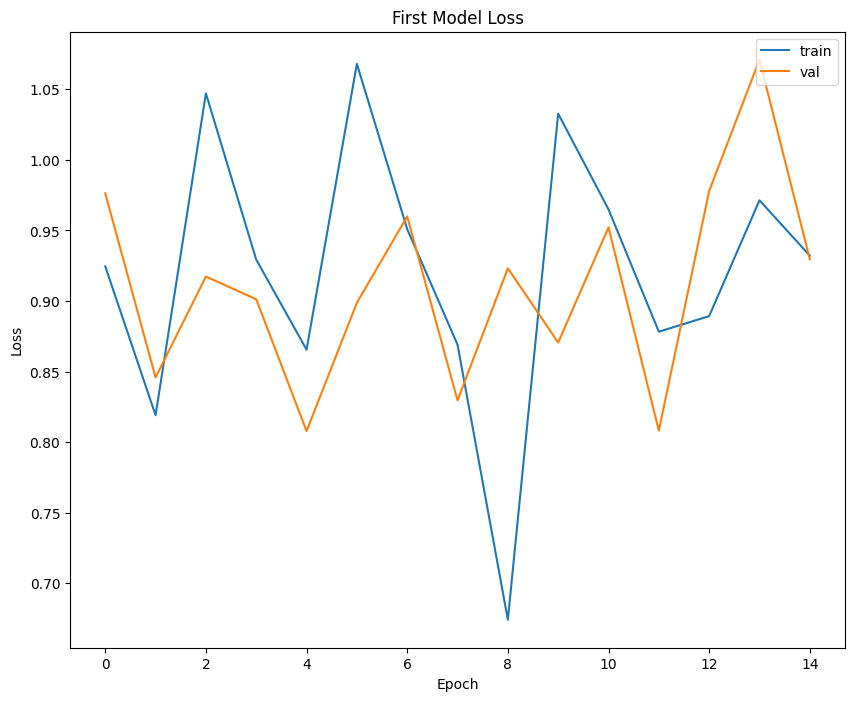

In [109]:
vocab_size = len(word2index)
embedding_dim = 100 
num_layers = 32
hidden_dim = 16
output = 3
dropout = 0.5
bidirectional = False
model = RNN_SentimentAnalysis(len(word2index), embedding_dim, num_layers, hidden_dim, bidirectional, output, dropout)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

epochs = 15
train_losses = []
val_losses = []
best_val = 100
best_model = None
for e in range(epochs):

    h0 =  model.init_hidden(batch_size)

    h0 = h0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, h0)
            # out = out.reshape(-1)
            target = torch.squeeze(target.float())
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    train_losses.append(loss.item())

    for batch_idx, batch in enumerate(validation_dl):
        input = batch[0].to(device)
        target = batch[1].to(device)
        with torch.set_grad_enabled(False):
            out, hidden = model(input, h0)
            _, preds = torch.max(out, 1)
            # out = out.reshape(-1)
            target = torch.squeeze(target.float())
            loss = criterion(out, target)
    val_loss = loss.item()
    val_losses.append(val_loss)
    if val_loss<best_val:
      best_val = val_loss
      best_model = model

plt.figure(figsize=(10, 8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [118]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):
    input = batch[0].to(device)
    target = batch[1].to(device)
    with torch.set_grad_enabled(False):
        out, hidden = best_model(input, h0)
        target = target.argmax (dim = 1)
        preds = out.argmax(dim=1)
        batch_acc.append(accuracy_score(preds, target))

print(sum(batch_acc) / len(batch_acc))

0.625
